# SSAP

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
%matplotlib inline

import sys
import os
import copy
import random
import datetime

import numpy as np
import pickle
import glob
from tqdm import tqdm
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from pycocotools.coco import COCO

In [3]:
sys.path.append('../src/')

from SSAP import SSAP
from mydatasets import preprocess, Mydatasets, TdwAffinityDataset
from loss import focal_loss, l2_loss, calc_loss
from graph_partition import Partition, Edge, greedy_additive, \
                            calc_js_div, make_ins_seg

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [4]:
def num_parameters(m):
    return sum([np.prod(v.shape) for v in m.parameters()])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Prepare

In [5]:
# classとclassの色の呼び出し
with open('../data/t_class_name.txt', 'rb') as f:
    t_class_name = pickle.load(f)
with open('../data/t_color.txt', 'rb') as f:
    t_color = pickle.load(f)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
DATA_PATH = "../data/resize/"
IMG_SIZE = 224
# Affinity計算範囲
AFF_R = 5

mean = [0.477, 0.451, 0.411]
std = [0.284, 0.280, 0.292]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cuda', index=0)

In [9]:
model = SSAP(n_channels=3, n_classes=len(t_color), aff_r=AFF_R)
model = model.to(device)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train

In [10]:
# 実験ごとに名前(exp_1)を変更する.
name = "../exp/exp_1/"

!mkdir -p $name
graph = name + "graph/"
!mkdir -p $graph
metrics = name + "metrics/"
!mkdir -p $metrics
trained_model = name + "trained_model/"
!mkdir -p $trained_model

BATCH_SIZE = 10
# BATCH_SIZE = 1

# EPOCH = 100000
EPOCH = 1
SAVE_ITER = 50
# SAVe_ITER = 10
LOG_ITER = 10
# LOG_ITER = 1

aff_calc_weight = [1.5, 0.5]
aff_weight = 1.
l_aff_weight = [1., 0.3, 0.1, 0.03, 0.01]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# 各値の初期化
random.seed(0)  
np.random.seed(0)  
torch.manual_seed(0)
# img_path = DATA_PATH + "train2014/"
# img_t_path = DATA_PATH + "semantic_train/"
# img_t_ins_path = DATA_PATH + "instance_train/"

img_path = DATA_PATH + "val2017/"
img_t_path = DATA_PATH + "semantic_val/"
img_t_ins_path = DATA_PATH + "instance_val/"

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
len(glob.glob(img_path + '/*'))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5000

In [13]:
# Datasetの設定
dataset = Mydatasets(t_color, img_path, img_t_path, img_t_ins_path,
                     IMG_SIZE, AFF_R, mean, std)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE,
                                          shuffle = True, num_workers = 4)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## look at example

In [14]:
data = dataset[0]
for v in data:
    print(v.dtype, v.shape)

torch.float32 torch.Size([3, 224, 224])
torch.float64 torch.Size([81, 224, 224])
torch.float32 torch.Size([5, 25, 224, 224])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


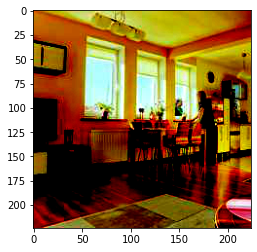

In [15]:
img, semantic, aff_target = data
plt.imshow(img.permute(1,2,0).numpy())
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


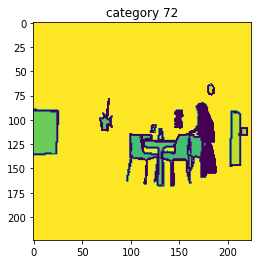

In [16]:
cats = torch.unique(semantic.argmax(0))
cat_idx = cats[np.random.randint(1, len(cats))]
# plt.imshow(semantic[cat_idx].numpy())
plt.imshow(semantic.argmax(0).numpy())
# plt.imshow(semantic[cat_idx].numpy())
plt.title('category %d' % cat_idx)
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


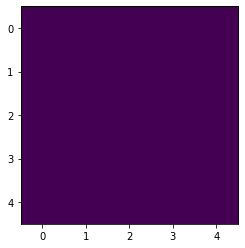

tensor([1.])


In [17]:
level = 0
node = (50,28)
affs = aff_target[level,:,node[0],node[1]].view(AFF_R, AFF_R)
plt.imshow(affs.numpy())
plt.show()
print(torch.unique(affs))

## train model

In [18]:
# Optimizerの指定
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


iter:10, loss:5.9695, loss_seg:5.8348, loss_aff:0.1347
iter:20, loss:5.1443, loss_seg:5.0460, loss_aff:0.0983
iter:30, loss:4.4701, loss_seg:4.3854, loss_aff:0.0847
iter:40, loss:4.0379, loss_seg:3.9673, loss_aff:0.0706
iter:50, loss:3.5558, loss_seg:3.4896, loss_aff:0.0662


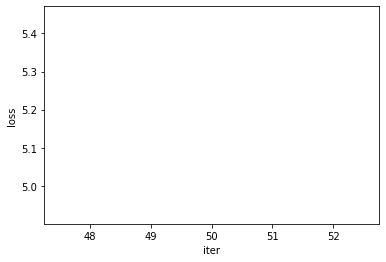

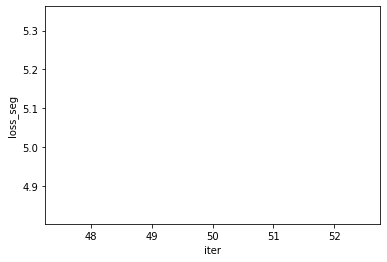

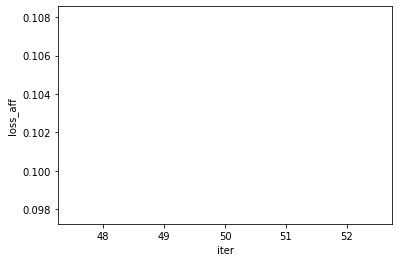

iter:60, loss:2.9468, loss_seg:2.8923, loss_aff:0.0545
iter:70, loss:2.7116, loss_seg:2.6632, loss_aff:0.0484
iter:80, loss:2.5920, loss_seg:2.5502, loss_aff:0.0419
iter:90, loss:2.4941, loss_seg:2.4577, loss_aff:0.0364
iter:100, loss:2.3988, loss_seg:2.3658, loss_aff:0.0330


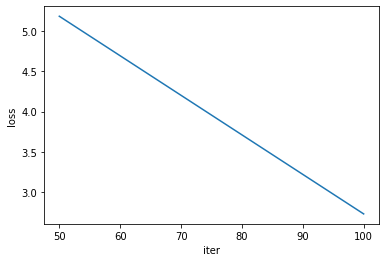

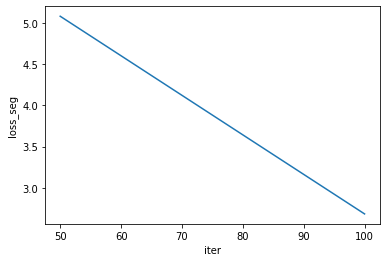

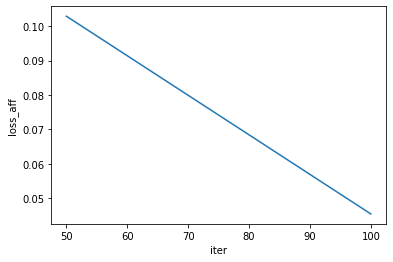

iter:110, loss:2.3108, loss_seg:2.2815, loss_aff:0.0293
iter:120, loss:2.2175, loss_seg:2.1911, loss_aff:0.0264
iter:130, loss:2.0924, loss_seg:2.0685, loss_aff:0.0239
iter:140, loss:1.9168, loss_seg:1.8944, loss_aff:0.0224
iter:150, loss:1.7347, loss_seg:1.7149, loss_aff:0.0198


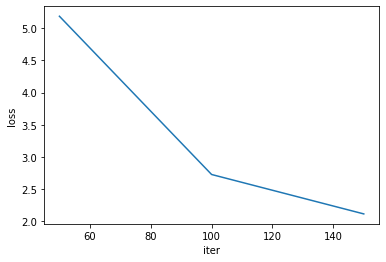

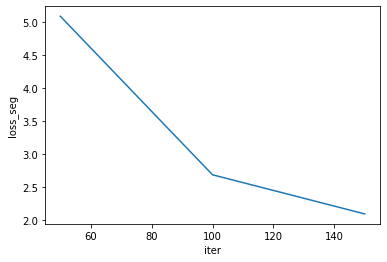

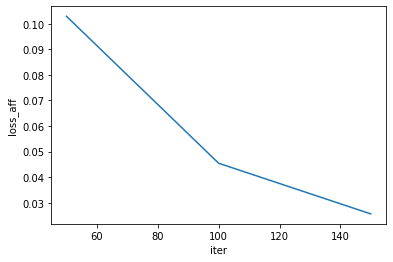

iter:160, loss:1.4444, loss_seg:1.4251, loss_aff:0.0193
iter:170, loss:1.2906, loss_seg:1.2727, loss_aff:0.0179
iter:180, loss:1.1948, loss_seg:1.1779, loss_aff:0.0169
iter:190, loss:1.1321, loss_seg:1.1162, loss_aff:0.0159
iter:200, loss:1.0821, loss_seg:1.0683, loss_aff:0.0138


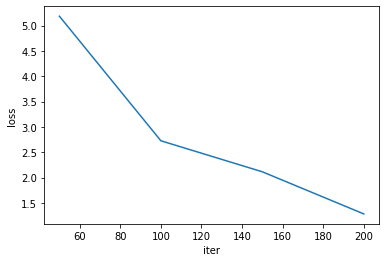

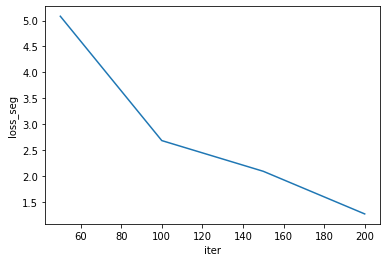

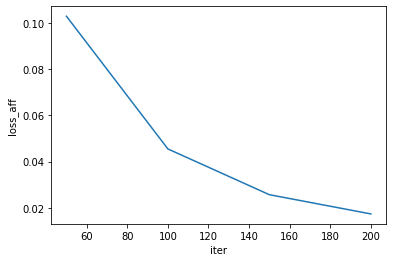

iter:210, loss:1.0477, loss_seg:1.0343, loss_aff:0.0134
iter:220, loss:1.0169, loss_seg:1.0048, loss_aff:0.0121
iter:230, loss:0.9894, loss_seg:0.9783, loss_aff:0.0111
iter:240, loss:0.9610, loss_seg:0.9503, loss_aff:0.0106
iter:250, loss:0.9172, loss_seg:0.9071, loss_aff:0.0101


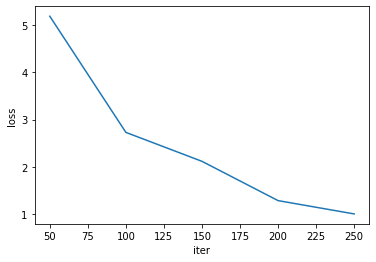

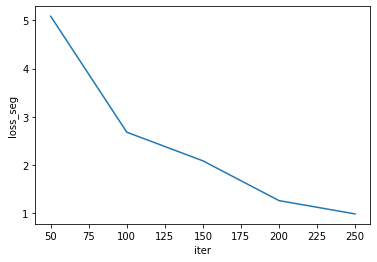

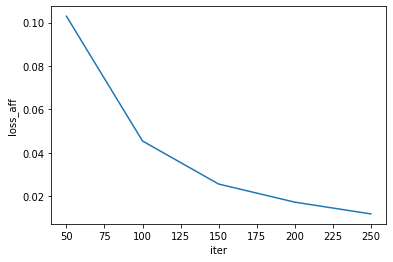

iter:260, loss:0.8341, loss_seg:0.8246, loss_aff:0.0095
iter:270, loss:0.8051, loss_seg:0.7962, loss_aff:0.0089
iter:280, loss:0.7893, loss_seg:0.7808, loss_aff:0.0085
iter:290, loss:0.7797, loss_seg:0.7717, loss_aff:0.0079
iter:300, loss:0.7733, loss_seg:0.7658, loss_aff:0.0075


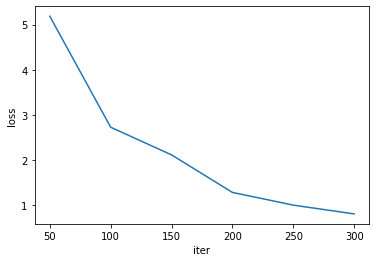

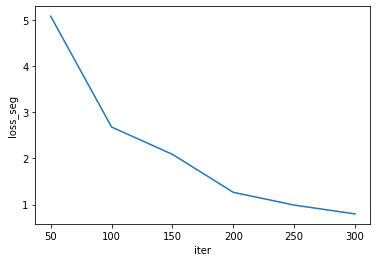

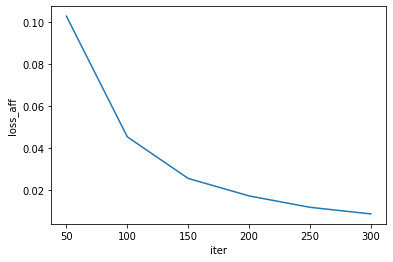

iter:310, loss:0.7687, loss_seg:0.7617, loss_aff:0.0071
iter:320, loss:0.7653, loss_seg:0.7586, loss_aff:0.0067
iter:330, loss:0.7625, loss_seg:0.7560, loss_aff:0.0065
iter:340, loss:0.7600, loss_seg:0.7538, loss_aff:0.0062
iter:350, loss:0.7581, loss_seg:0.7522, loss_aff:0.0059


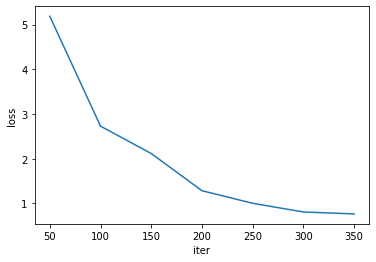

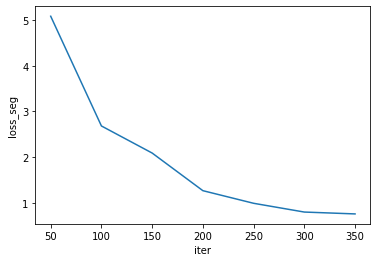

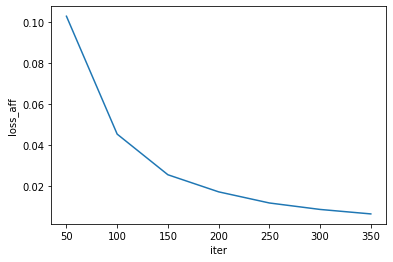

iter:360, loss:0.7565, loss_seg:0.7509, loss_aff:0.0056
iter:370, loss:0.7548, loss_seg:0.7494, loss_aff:0.0053
iter:380, loss:0.7535, loss_seg:0.7484, loss_aff:0.0051
iter:390, loss:0.7526, loss_seg:0.7477, loss_aff:0.0049
iter:400, loss:0.7519, loss_seg:0.7472, loss_aff:0.0047


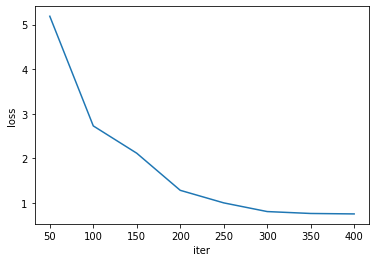

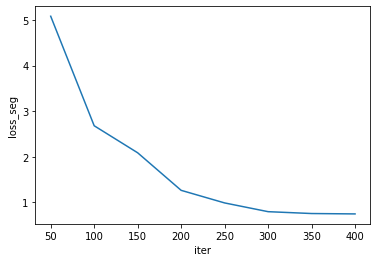

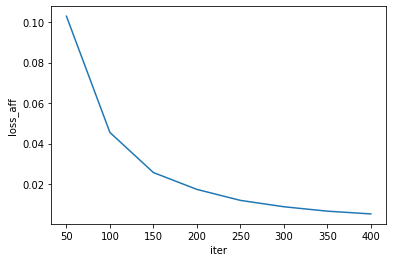

iter:410, loss:0.7512, loss_seg:0.7467, loss_aff:0.0045
iter:420, loss:0.7506, loss_seg:0.7463, loss_aff:0.0043
iter:430, loss:0.7501, loss_seg:0.7459, loss_aff:0.0042
iter:440, loss:0.7496, loss_seg:0.7456, loss_aff:0.0040
iter:450, loss:0.7492, loss_seg:0.7453, loss_aff:0.0039


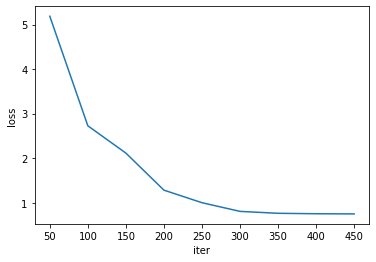

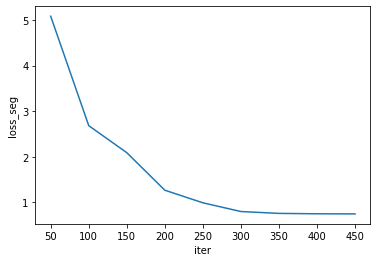

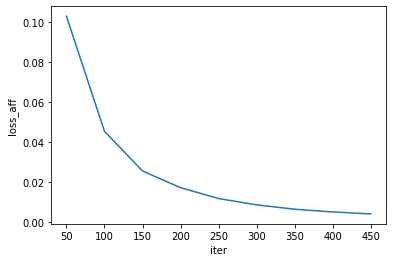

iter:460, loss:0.7487, loss_seg:0.7450, loss_aff:0.0037
iter:470, loss:0.7483, loss_seg:0.7447, loss_aff:0.0036
iter:480, loss:0.7478, loss_seg:0.7443, loss_aff:0.0035
iter:490, loss:0.7474, loss_seg:0.7440, loss_aff:0.0034
iter:500, loss:0.7470, loss_seg:0.7437, loss_aff:0.0033


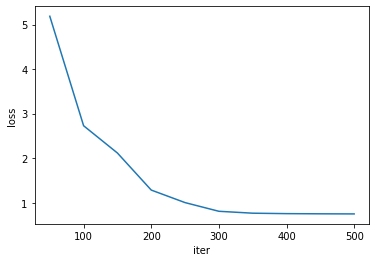

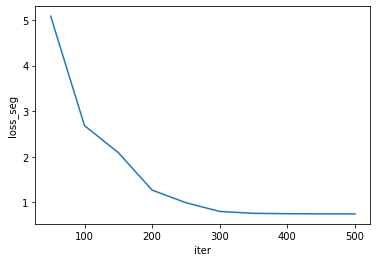

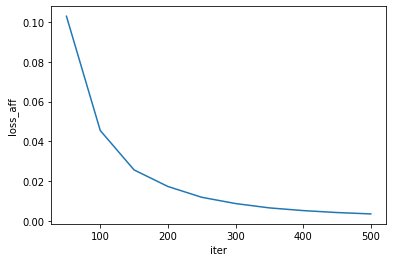

iter:510, loss:0.7465, loss_seg:0.7433, loss_aff:0.0032
iter:520, loss:0.7460, loss_seg:0.7429, loss_aff:0.0031
iter:530, loss:0.7457, loss_seg:0.7427, loss_aff:0.0030
iter:540, loss:0.7455, loss_seg:0.7425, loss_aff:0.0029
iter:550, loss:0.7452, loss_seg:0.7424, loss_aff:0.0028


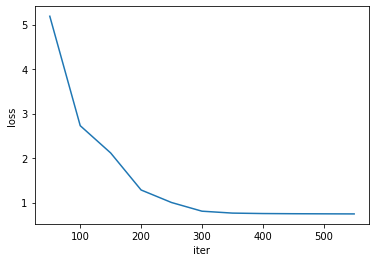

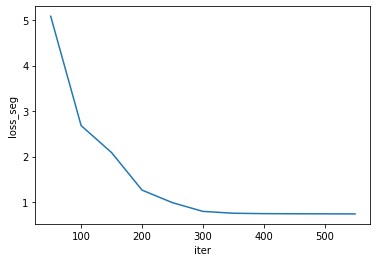

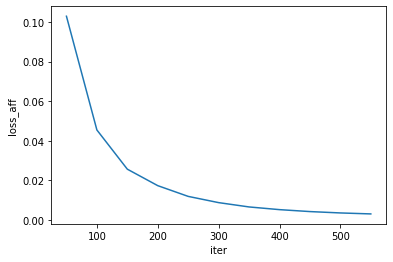

iter:560, loss:0.7450, loss_seg:0.7423, loss_aff:0.0028
iter:570, loss:0.7449, loss_seg:0.7422, loss_aff:0.0027
iter:580, loss:0.7447, loss_seg:0.7421, loss_aff:0.0026
iter:590, loss:0.7446, loss_seg:0.7420, loss_aff:0.0026
iter:600, loss:0.7444, loss_seg:0.7419, loss_aff:0.0025


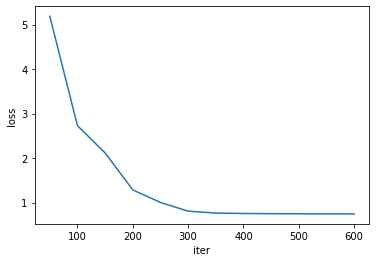

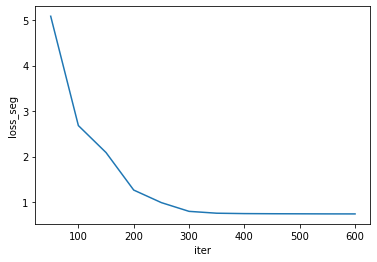

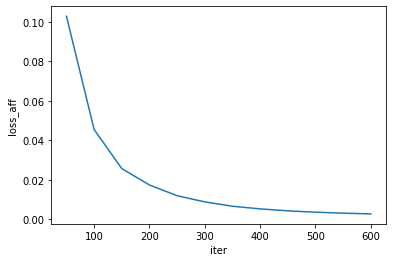

iter:610, loss:0.7443, loss_seg:0.7418, loss_aff:0.0024
iter:620, loss:0.7441, loss_seg:0.7418, loss_aff:0.0024
iter:630, loss:0.7440, loss_seg:0.7417, loss_aff:0.0023
iter:640, loss:0.7439, loss_seg:0.7416, loss_aff:0.0023
iter:650, loss:0.7438, loss_seg:0.7416, loss_aff:0.0023


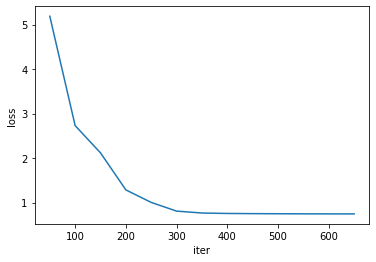

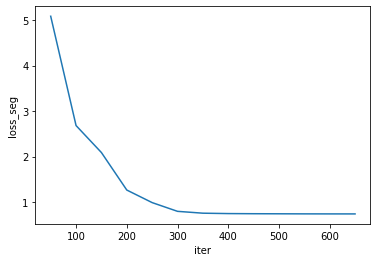

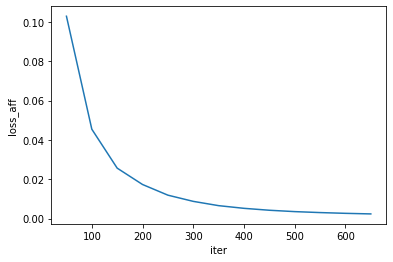

iter:660, loss:0.7437, loss_seg:0.7415, loss_aff:0.0022
iter:670, loss:0.7436, loss_seg:0.7415, loss_aff:0.0022
iter:680, loss:0.7435, loss_seg:0.7414, loss_aff:0.0021
iter:690, loss:0.7435, loss_seg:0.7414, loss_aff:0.0021
iter:700, loss:0.7434, loss_seg:0.7414, loss_aff:0.0020


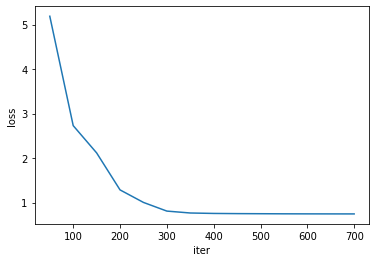

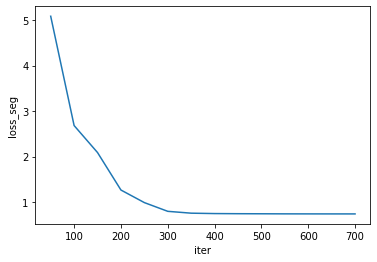

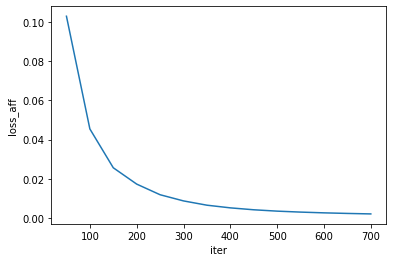

iter:710, loss:0.7433, loss_seg:0.7413, loss_aff:0.0020
iter:720, loss:0.7432, loss_seg:0.7413, loss_aff:0.0019
iter:730, loss:0.7431, loss_seg:0.7413, loss_aff:0.0019
iter:740, loss:0.7431, loss_seg:0.7412, loss_aff:0.0018
iter:750, loss:0.7430, loss_seg:0.7412, loss_aff:0.0018


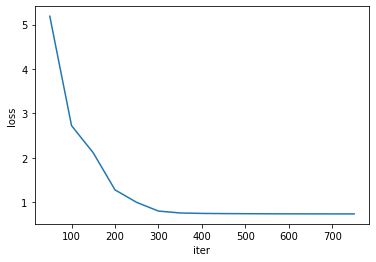

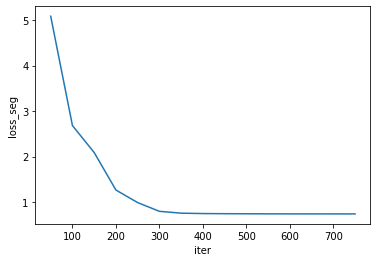

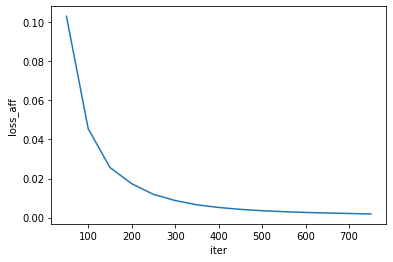

iter:760, loss:0.7429, loss_seg:0.7412, loss_aff:0.0018
iter:770, loss:0.7429, loss_seg:0.7411, loss_aff:0.0017
iter:780, loss:0.7428, loss_seg:0.7411, loss_aff:0.0017
iter:790, loss:0.7427, loss_seg:0.7411, loss_aff:0.0017
iter:800, loss:0.7427, loss_seg:0.7411, loss_aff:0.0016


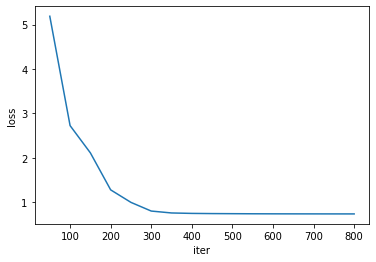

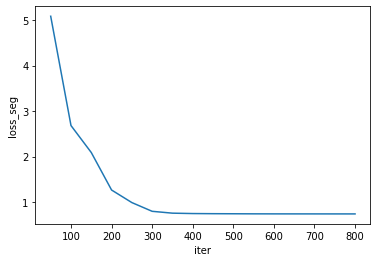

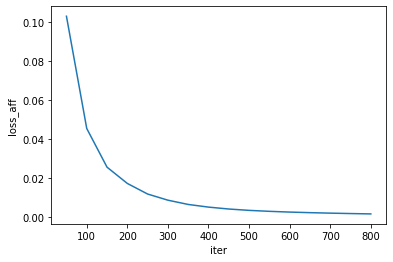

iter:810, loss:0.7426, loss_seg:0.7410, loss_aff:0.0016
iter:820, loss:0.7426, loss_seg:0.7410, loss_aff:0.0016
iter:830, loss:0.7425, loss_seg:0.7410, loss_aff:0.0016
iter:840, loss:0.7425, loss_seg:0.7410, loss_aff:0.0015
iter:850, loss:0.7424, loss_seg:0.7410, loss_aff:0.0015


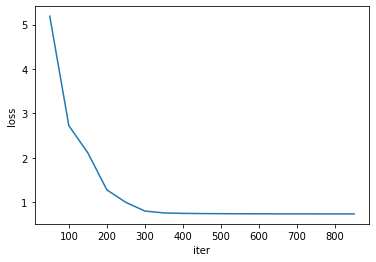

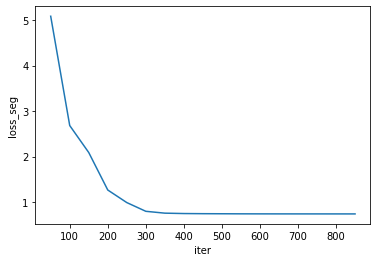

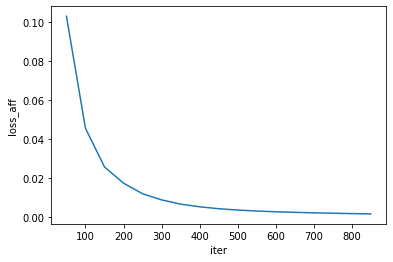

iter:860, loss:0.7424, loss_seg:0.7409, loss_aff:0.0015
iter:870, loss:0.7424, loss_seg:0.7409, loss_aff:0.0014
iter:880, loss:0.7423, loss_seg:0.7409, loss_aff:0.0014
iter:890, loss:0.7423, loss_seg:0.7409, loss_aff:0.0014
iter:900, loss:0.7422, loss_seg:0.7409, loss_aff:0.0014


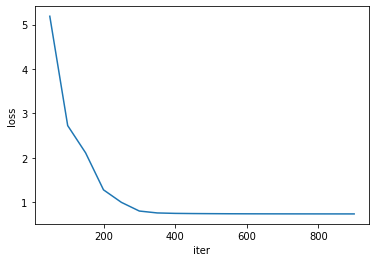

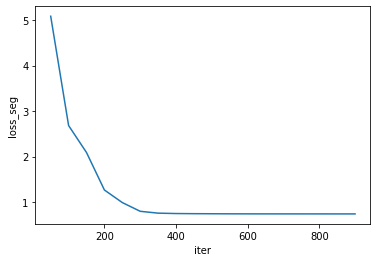

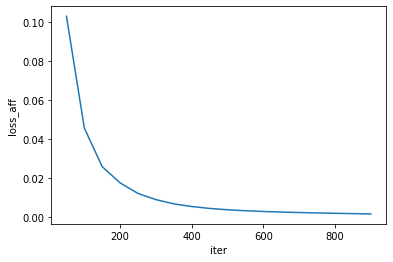

iter:910, loss:0.7422, loss_seg:0.7409, loss_aff:0.0013
iter:920, loss:0.7421, loss_seg:0.7409, loss_aff:0.0013
iter:930, loss:0.7421, loss_seg:0.7408, loss_aff:0.0013
iter:940, loss:0.7421, loss_seg:0.7408, loss_aff:0.0013
iter:950, loss:0.7420, loss_seg:0.7408, loss_aff:0.0012


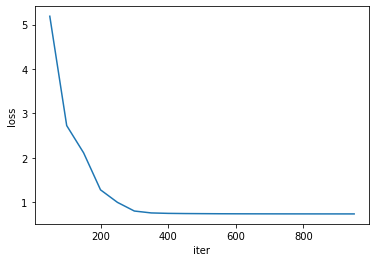

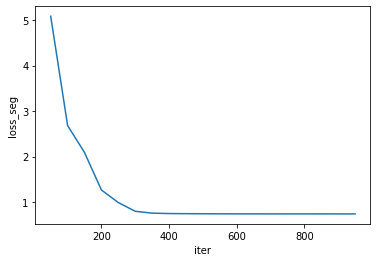

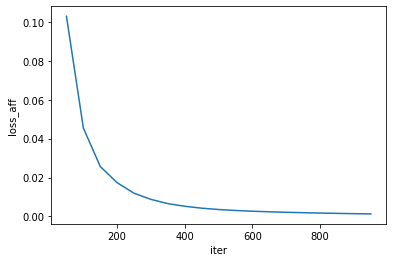

iter:960, loss:0.7420, loss_seg:0.7408, loss_aff:0.0012
iter:970, loss:0.7420, loss_seg:0.7408, loss_aff:0.0012
iter:980, loss:0.7419, loss_seg:0.7408, loss_aff:0.0011
iter:990, loss:0.7419, loss_seg:0.7408, loss_aff:0.0011
iter:1000, loss:0.7419, loss_seg:0.7408, loss_aff:0.0011


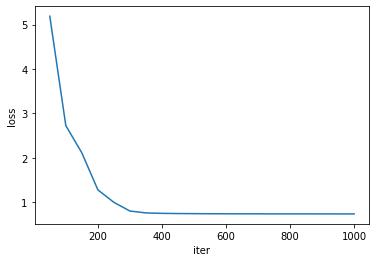

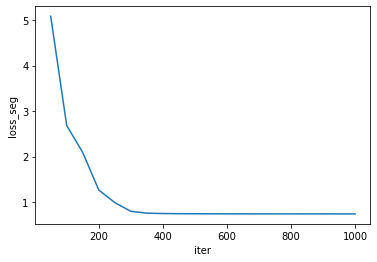

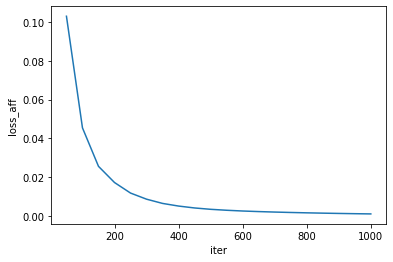

iter:1010, loss:0.7418, loss_seg:0.7408, loss_aff:0.0011
iter:1020, loss:0.7418, loss_seg:0.7407, loss_aff:0.0011
iter:1030, loss:0.7418, loss_seg:0.7407, loss_aff:0.0011
iter:1040, loss:0.7418, loss_seg:0.7407, loss_aff:0.0010
iter:1050, loss:0.7417, loss_seg:0.7407, loss_aff:0.0010


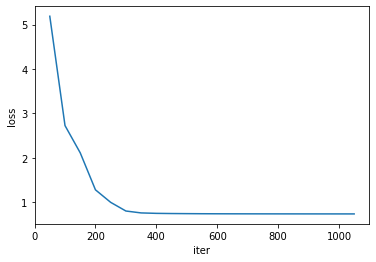

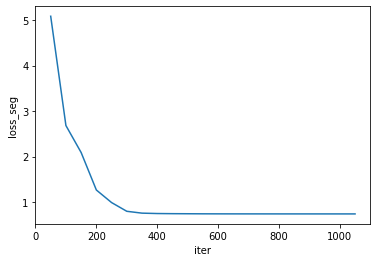

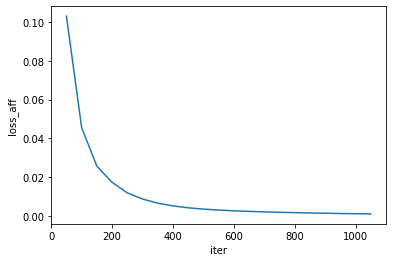

iter:1060, loss:0.7417, loss_seg:0.7407, loss_aff:0.0010
iter:1070, loss:0.7417, loss_seg:0.7407, loss_aff:0.0010
iter:1080, loss:0.7417, loss_seg:0.7407, loss_aff:0.0010
iter:1090, loss:0.7416, loss_seg:0.7407, loss_aff:0.0010
iter:1100, loss:0.7416, loss_seg:0.7407, loss_aff:0.0009


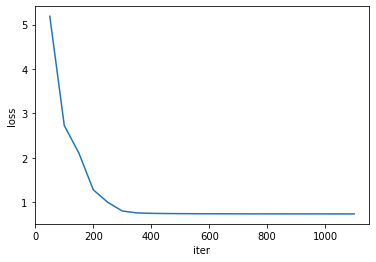

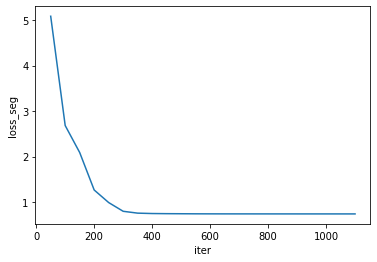

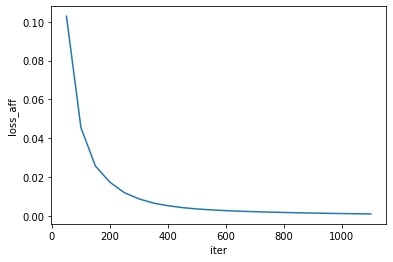

iter:1110, loss:0.7416, loss_seg:0.7407, loss_aff:0.0009
iter:1120, loss:0.7416, loss_seg:0.7407, loss_aff:0.0009
iter:1130, loss:0.7415, loss_seg:0.7406, loss_aff:0.0009
iter:1140, loss:0.7415, loss_seg:0.7406, loss_aff:0.0009
iter:1150, loss:0.7415, loss_seg:0.7406, loss_aff:0.0009


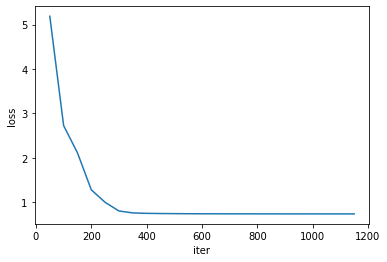

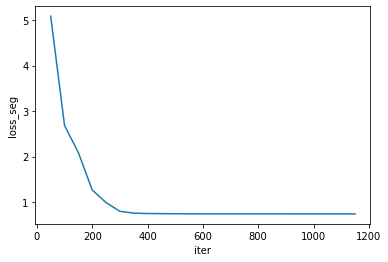

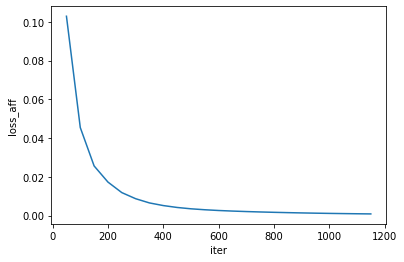

iter:1160, loss:0.7415, loss_seg:0.7406, loss_aff:0.0009
iter:1170, loss:0.7415, loss_seg:0.7406, loss_aff:0.0008
iter:1180, loss:0.7414, loss_seg:0.7406, loss_aff:0.0008
iter:1190, loss:0.7414, loss_seg:0.7406, loss_aff:0.0008
iter:1200, loss:0.7414, loss_seg:0.7406, loss_aff:0.0008


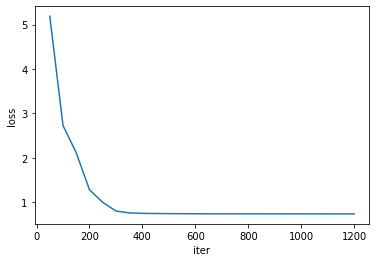

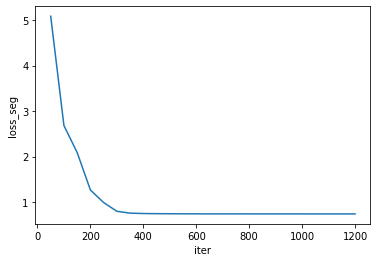

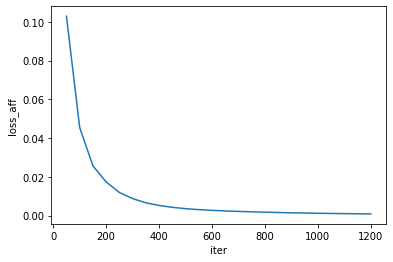

iter:1210, loss:0.7414, loss_seg:0.7406, loss_aff:0.0008
iter:1220, loss:0.7414, loss_seg:0.7406, loss_aff:0.0008
iter:1230, loss:0.7413, loss_seg:0.7406, loss_aff:0.0008
iter:1240, loss:0.7413, loss_seg:0.7406, loss_aff:0.0008
iter:1250, loss:0.7413, loss_seg:0.7406, loss_aff:0.0007


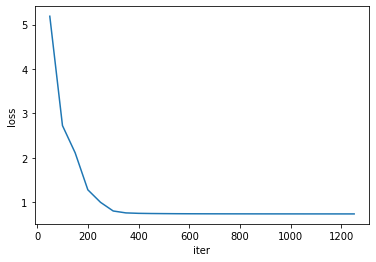

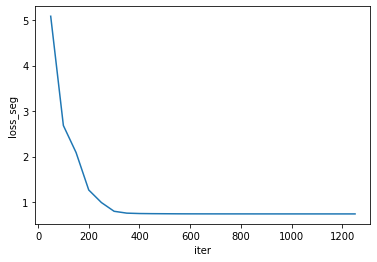

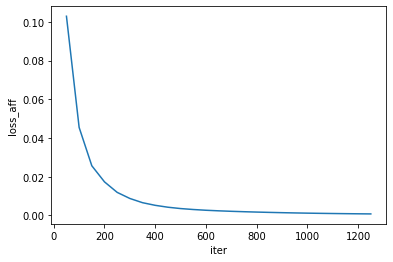

iter:1260, loss:0.7413, loss_seg:0.7406, loss_aff:0.0007
iter:1270, loss:0.7413, loss_seg:0.7406, loss_aff:0.0007
iter:1280, loss:0.7413, loss_seg:0.7406, loss_aff:0.0007
iter:1290, loss:0.7413, loss_seg:0.7406, loss_aff:0.0007
iter:1300, loss:0.7412, loss_seg:0.7405, loss_aff:0.0007


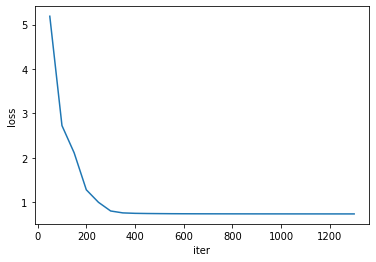

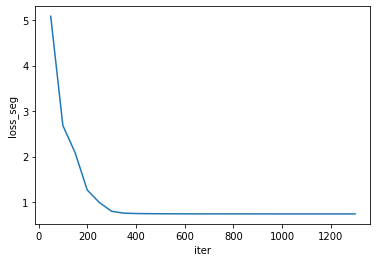

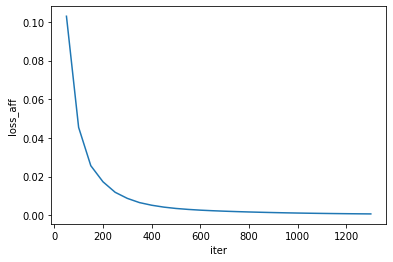

iter:1310, loss:0.7412, loss_seg:0.7405, loss_aff:0.0007
iter:1320, loss:0.7412, loss_seg:0.7405, loss_aff:0.0007
iter:1330, loss:0.7412, loss_seg:0.7405, loss_aff:0.0007
iter:1340, loss:0.7412, loss_seg:0.7405, loss_aff:0.0007
iter:1350, loss:0.7412, loss_seg:0.7405, loss_aff:0.0006


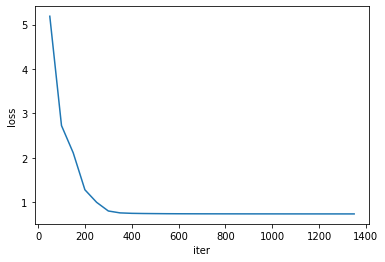

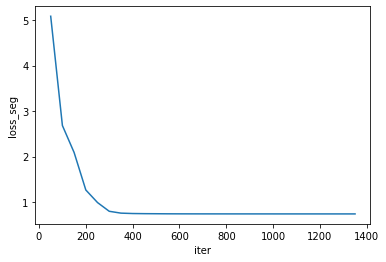

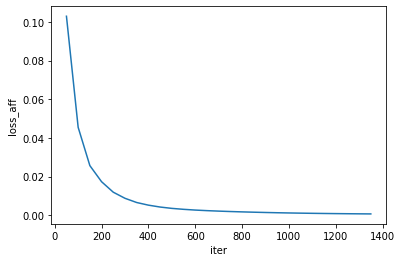

iter:1360, loss:0.7412, loss_seg:0.7405, loss_aff:0.0006
iter:1370, loss:0.7412, loss_seg:0.7405, loss_aff:0.0006
iter:1380, loss:0.7411, loss_seg:0.7405, loss_aff:0.0006
iter:1390, loss:0.7411, loss_seg:0.7405, loss_aff:0.0006
iter:1400, loss:0.7411, loss_seg:0.7405, loss_aff:0.0006


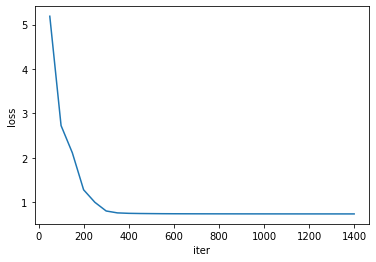

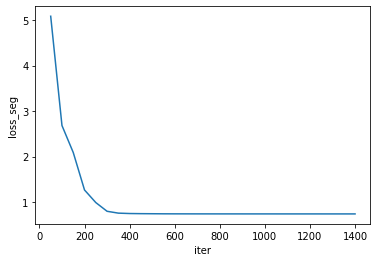

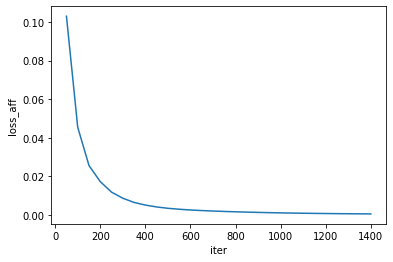

iter:1410, loss:0.7411, loss_seg:0.7405, loss_aff:0.0006
iter:1420, loss:0.7411, loss_seg:0.7405, loss_aff:0.0006
iter:1430, loss:0.7411, loss_seg:0.7405, loss_aff:0.0006
iter:1440, loss:0.7411, loss_seg:0.7405, loss_aff:0.0006
iter:1450, loss:0.7411, loss_seg:0.7405, loss_aff:0.0006


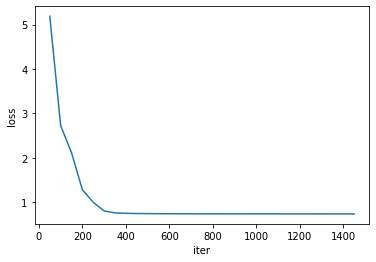

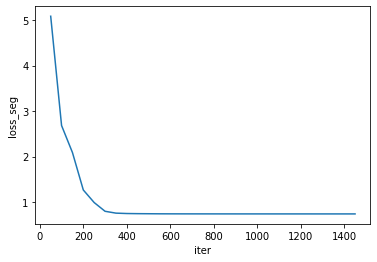

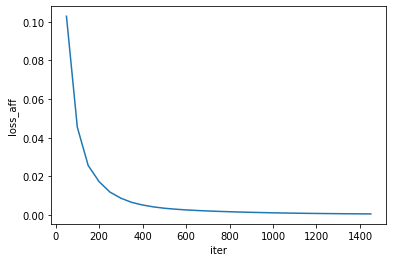

iter:1460, loss:0.7411, loss_seg:0.7405, loss_aff:0.0006
iter:1470, loss:0.7410, loss_seg:0.7405, loss_aff:0.0006
iter:1480, loss:0.7410, loss_seg:0.7405, loss_aff:0.0006
iter:1490, loss:0.7410, loss_seg:0.7405, loss_aff:0.0006
iter:1500, loss:0.7410, loss_seg:0.7405, loss_aff:0.0005


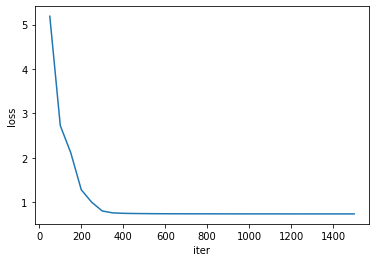

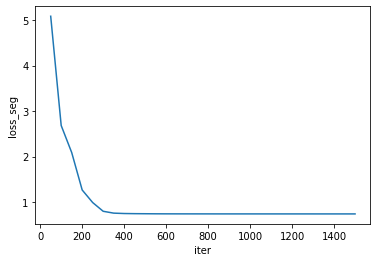

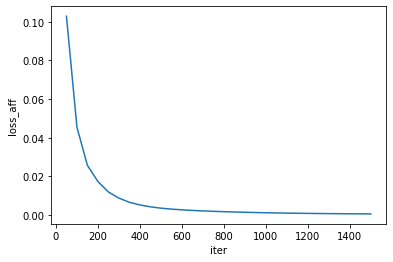

iter:1510, loss:0.7410, loss_seg:0.7405, loss_aff:0.0005
iter:1520, loss:0.7410, loss_seg:0.7405, loss_aff:0.0005
iter:1530, loss:0.7410, loss_seg:0.7405, loss_aff:0.0005
iter:1540, loss:0.7410, loss_seg:0.7405, loss_aff:0.0005
iter:1550, loss:0.7410, loss_seg:0.7405, loss_aff:0.0005


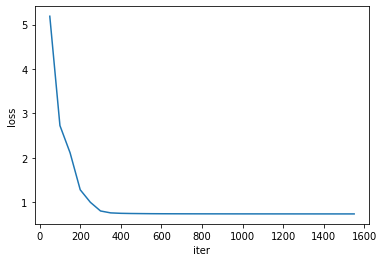

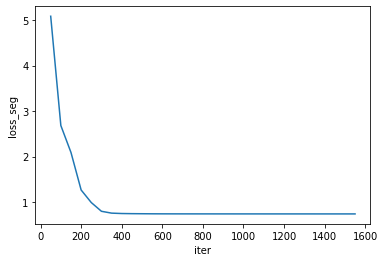

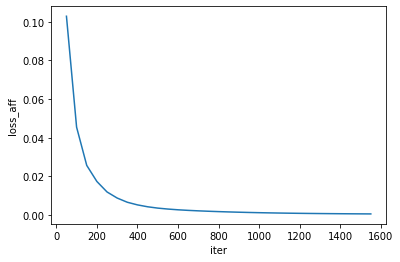

iter:1560, loss:0.7410, loss_seg:0.7405, loss_aff:0.0005
iter:1570, loss:0.7410, loss_seg:0.7405, loss_aff:0.0005
iter:1580, loss:0.7410, loss_seg:0.7405, loss_aff:0.0005
iter:1590, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005
iter:1600, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005


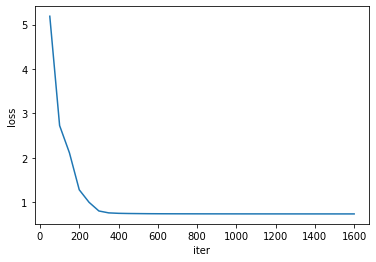

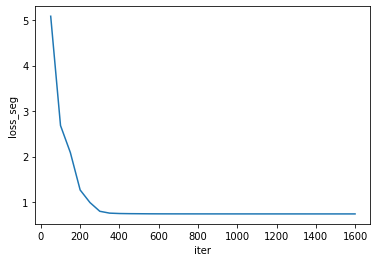

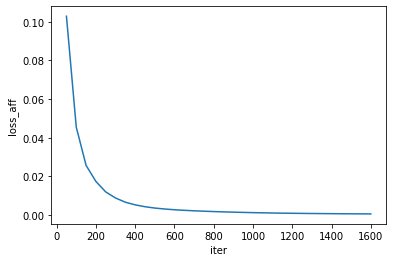

iter:1610, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005
iter:1620, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005
iter:1630, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005
iter:1640, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005
iter:1650, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005


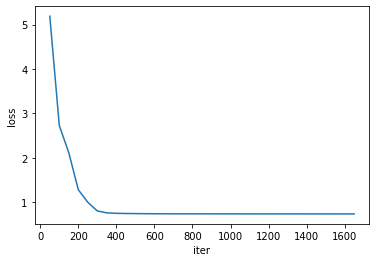

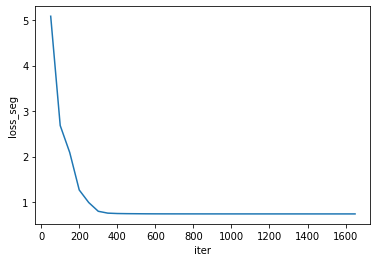

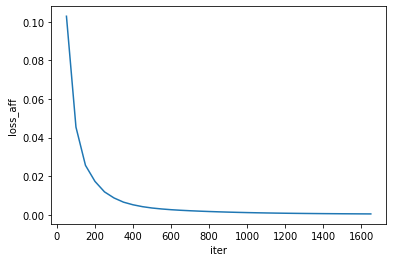

iter:1660, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005
iter:1670, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005
iter:1680, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005
iter:1690, loss:0.7409, loss_seg:0.7404, loss_aff:0.0005
iter:1700, loss:0.7409, loss_seg:0.7404, loss_aff:0.0004


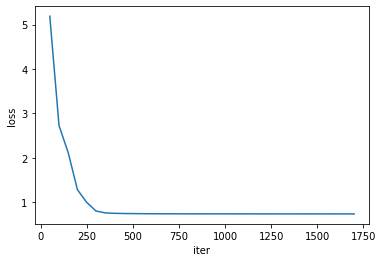

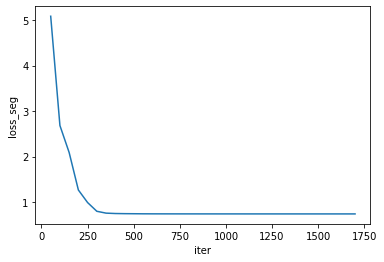

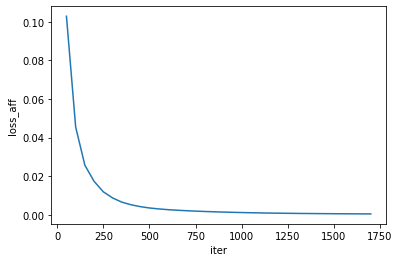

iter:1710, loss:0.7409, loss_seg:0.7404, loss_aff:0.0004
iter:1720, loss:0.7409, loss_seg:0.7404, loss_aff:0.0004
iter:1730, loss:0.7409, loss_seg:0.7404, loss_aff:0.0004
iter:1740, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1750, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004


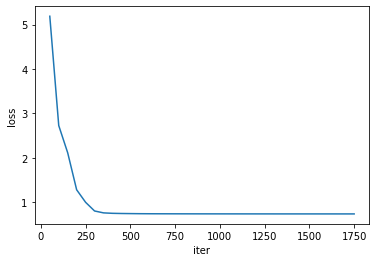

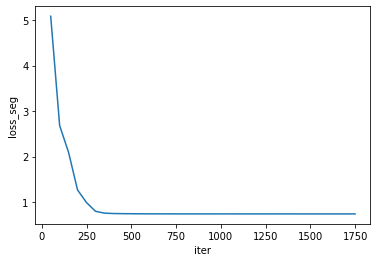

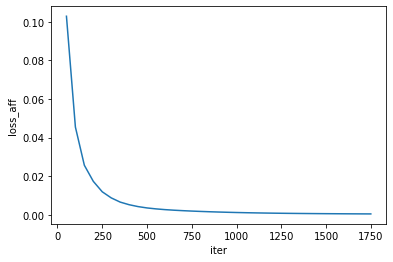

iter:1760, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1770, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1780, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1790, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1800, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004


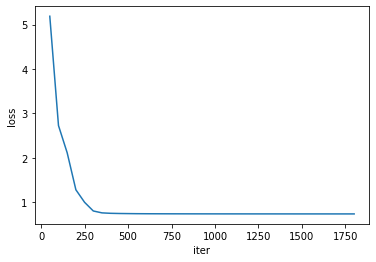

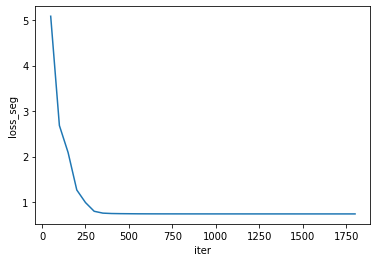

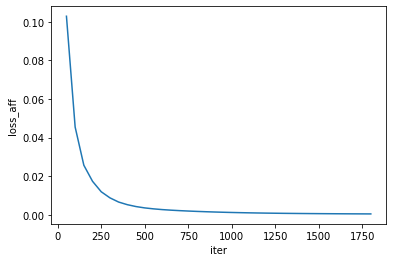

iter:1810, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1820, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1830, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1840, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1850, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004


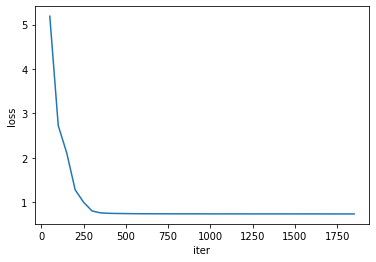

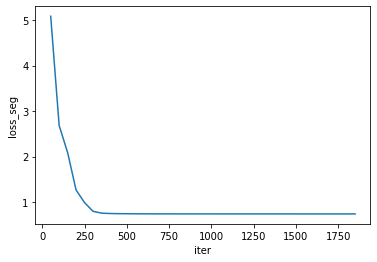

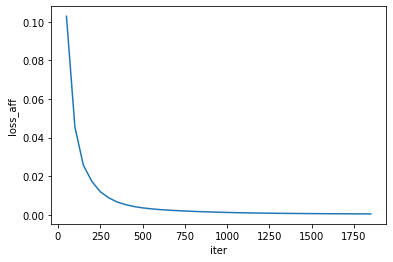

iter:1860, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1870, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1880, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1890, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1900, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004


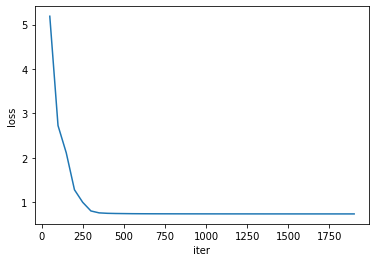

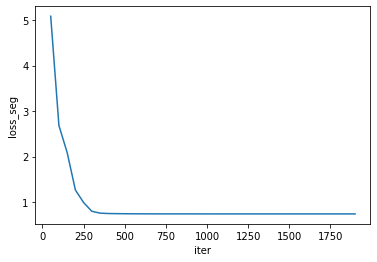

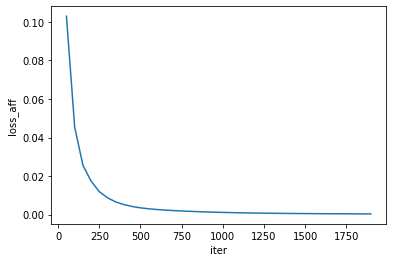

iter:1910, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004
iter:1920, loss:0.7408, loss_seg:0.7404, loss_aff:0.0004


KeyboardInterrupt: 

In [19]:
iter_ = 0
running_loss = 0.0
running_loss_seg = 0.0
running_loss_aff = 0.0
y_loss_axis = []
y_loss_seg_axis = []
y_loss_aff_axis = []
x_axis = []

for epoch in range(EPOCH):  
    for i in range(500):
        data = [x[None] for x in dataset[0]]
#     for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels, t_aff = data
        inputs = inputs.to(device)
        labels = labels.type(torch.float32)
        labels = labels.to(device)
        t_aff = t_aff.type(torch.float32)
        t_aff = t_aff.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss_seg, loss_aff = calc_loss(outputs, labels, 
                                       t_aff, aff_calc_weight, 
                                       aff_weight, l_aff_weight)
        loss = loss_seg + loss_aff
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        running_loss_seg += loss_seg.data
        running_loss_aff += loss_aff.data

        iter_ += 1
        
        # logの表示
        if iter_ % LOG_ITER == 0:
            with open(name + "log", mode='a') as f:
                f.write("time:{}, epoch:{}, iter:{}, loss:{:.4f}, loss_seg:{:.4f}, loss_aff:{:.4f}\n"
                        .format(datetime.datetime.now(), epoch, iter_, 
                                loss.data, loss_seg.data, loss_aff.data))
            print("iter:{}, loss:{:.4f}, loss_seg:{:.4f}, loss_aff:{:.4f}"
                  .format(iter_, loss.data, loss_seg.data, loss_aff.data))

        if iter_ % SAVE_ITER == 0:
            # lossのグラフ作成
            x_axis.append(iter_)
            y_loss_axis.append(running_loss.item() / SAVE_ITER)
            y_loss_seg_axis.append(running_loss_seg.item() / SAVE_ITER)
            y_loss_aff_axis.append(running_loss_aff.item() / SAVE_ITER)

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss")
            plt.plot(np.array(x_axis),np.array(y_loss_axis))
#             fig.savefig(graph + "loss.png")

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss_seg")
            plt.plot(np.array(x_axis),np.array(y_loss_seg_axis))
#             fig.savefig(graph + "loss_seg.png")

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss_aff")
            plt.plot(np.array(x_axis),np.array(y_loss_aff_axis))
#             fig.savefig(graph + "loss_aff.png")            

            plt.show()
    
            running_loss = 0.0
            running_loss_seg = 0.0
            running_loss_aff = 0.0

#             torch.save(model.state_dict(), trained_model + "model_" + str(iter_) + ".pth")

print('Finished Training')

# test

In [19]:
# # 評価するモデルとiterationを指定.
# pre_name = "../exp/exp_1/"
# iter_ = "750000"
# model = SSAP(n_channels=3, n_classes=len(t_color), aff_r=AFF_R)
# model = model.to(device)
# model.eval()
# model.load_state_dict(torch.load(pre_name + 'trained_model/model_' + iter_ + '.pth'))

<All keys matched successfully>

In [20]:
model.eval()
print(num_parameters(model))

48401722


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
data_type = "val"
img_path = sorted(glob.glob(DATA_PATH + data_type + "2017/*"))
img_t_path = sorted(glob.glob(DATA_PATH + "semantic_" + data_type + "/*"))
img_ins_t_path = sorted(glob.glob(DATA_PATH + "instance_" + data_type + "/*"))
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# cocoデータセット呼び出し
annFile='../data/annotations/instances_%s2017.json'%(data_type)
coco=COCO(annFile)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [23]:
# クラスとcocoデータセット内でのIndexを渡すと、評価データ内のIndexを返す.
def get_img_ind(cls_ind=0, img_ind=0):
    catIds = coco.getCatIds(catNms=[t_class_name[cls_ind]]);
    imgIds = sorted(coco.getImgIds(catIds=catIds));
    img_name = coco.loadImgs(imgIds[img_ind])[0]['file_name']
    img_name = DATA_PATH + data_type + "2017/" + img_name
    ind_ = img_path.index(img_name)
    print(t_class_name[cls_ind], ind_)
    return ind_

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Semantic Segmentation
def semantic(ind=0, cls_=0):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))
    img_ins_t = np.asarray(Image.open(img_ins_t_path[ind]))
    img_t = np.where((img_t[:, :, 0] == t_color[cls_][0])
                     & (img_t[:, :, 1] == t_color[cls_][1])
                     & (img_t[:, :, 2] == t_color[cls_][2]),
                     1, 0)[..., None]
    img_ins_t = img_ins_t * img_t
    img_t = np.tile(img_t, (1, 1, 3))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
    
    print("pic_name:{}".format(img_path[ind]))

    output = outputs[4].cpu().detach().numpy()
    output = np.array(np.argmax(output[0], axis=0))
    output = np.where(output==cls_, 1, 0)

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(131, title='input')
    ax1.imshow(np.array(img, dtype=np.int32))
    ax2 = fig.add_subplot(132, title='correct_instance')
    ax2.imshow(np.array(img_ins_t, dtype=np.int32))
    ax3 = fig.add_subplot(133, title='detect_instance')
    ax3.imshow(output)
    plt.show()

    return outputs

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# Instance Segmentation
def instance(ind=0, cls_=0, st_for=0, en_for=5, min_size=5):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))
    img_ins_t = np.asarray(Image.open(img_ins_t_path[ind]))
    img_t = np.where((img_t[:, :, 0] == t_color[cls_][0])
                      & (img_t[:, :, 1] == t_color[cls_][1])
                      & (img_t[:, :, 2] == t_color[cls_][2]),
                     1, 0)[..., None]
    img_ins_t = img_ins_t * img_t
    img_t = np.tile(img_t, (1, 1, 3))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
    
    print("pic_name:{}".format(img_path[ind]))
    
    ins, ins_list = make_ins_seg(outputs, st_for=st_for,
                                 en_for=en_for, min_size=min_size)

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(131, title='input')
    ax1.imshow(np.array(img, dtype=np.int32))
    ax2 = fig.add_subplot(132, title='correct_instance')
    ax2.imshow(np.array(img_ins_t, dtype=np.int32))
    ax3 = fig.add_subplot(133, title='detect_instance')
    ax3.imshow(ins[cls_])
    plt.show()

    return outputs, ins

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 0
pic_name:../data/resize/val2017/000000000139.jpg


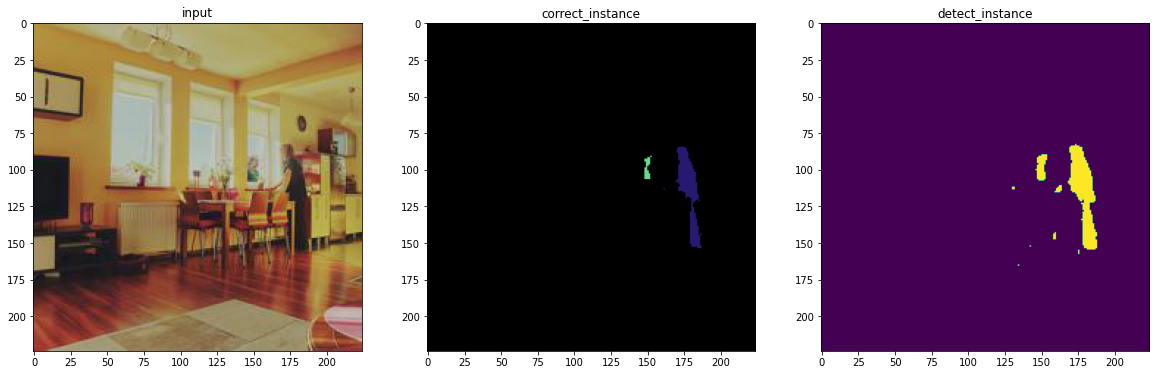

In [26]:
cls_ind = 0
img_ind = 0
ind = get_img_ind(cls_ind, img_ind)
outputs = semantic(ind=ind, cls_=cls_ind)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 0
pic_name:../data/resize/val2017/000000000139.jpg


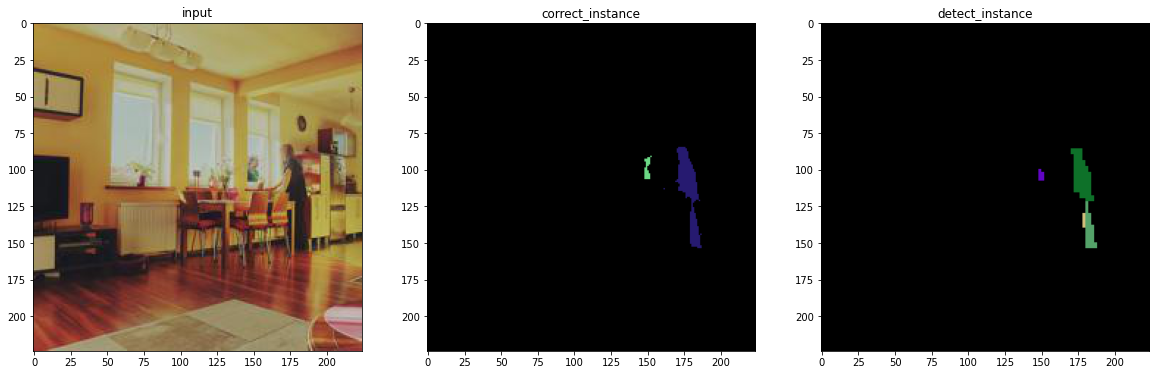

In [33]:
cls_ind = 0
img_ind = 0
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 1845
pic_name:../data/resize/val2017/000000212453.jpg


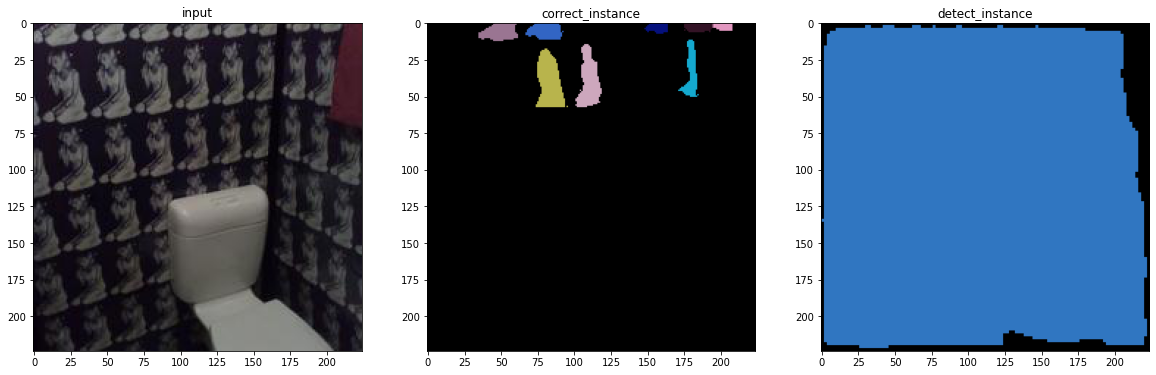

In [26]:
cls_ind = 0
img_ind = 1000
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 191
pic_name:../data/resize/val2017/000000019221.jpg


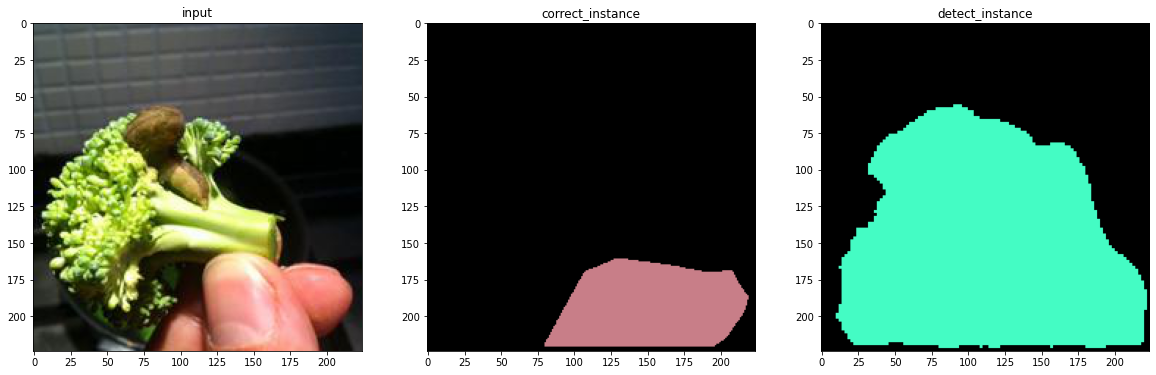

In [27]:
cls_ind = 0
img_ind = 105
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


elephant 710
pic_name:../data/resize/val2017/000000083113.jpg


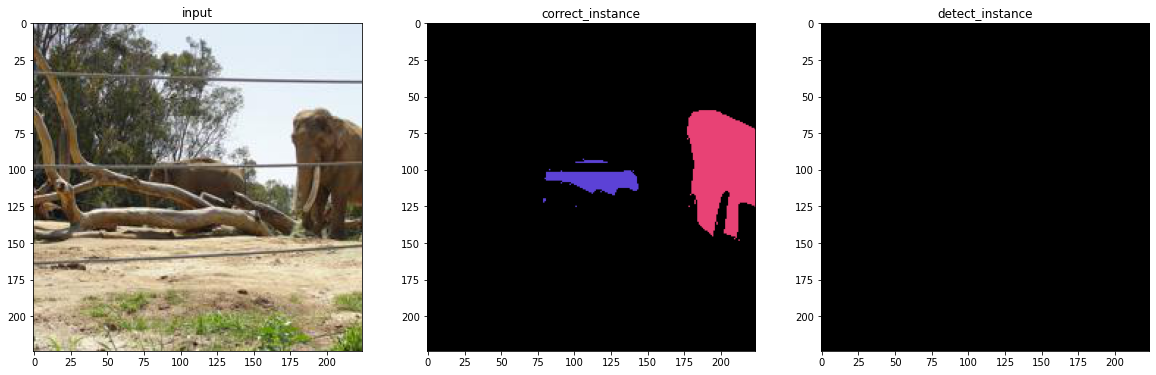

In [29]:
cls_ind = 20
img_ind = 10
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

keyboard 2630
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000036484.jpg


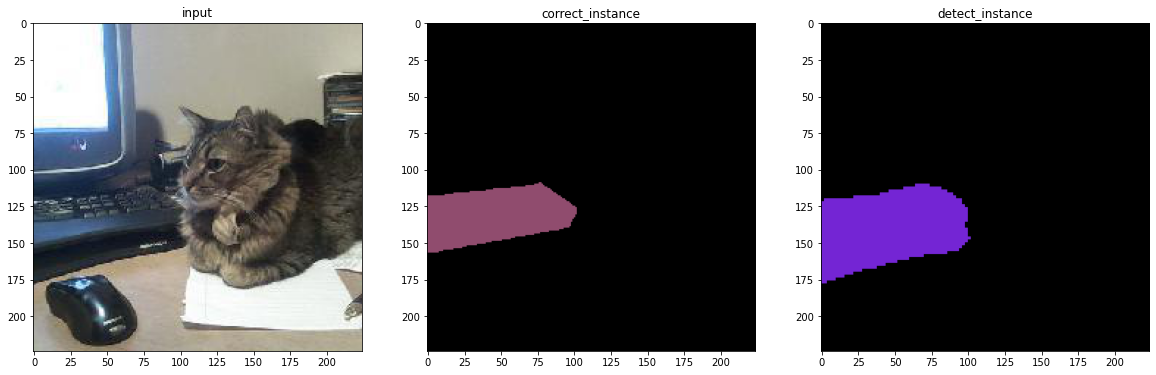

In [21]:
cls_ind = 66
img_ind = 44
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

stop sign 401
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000005635.jpg


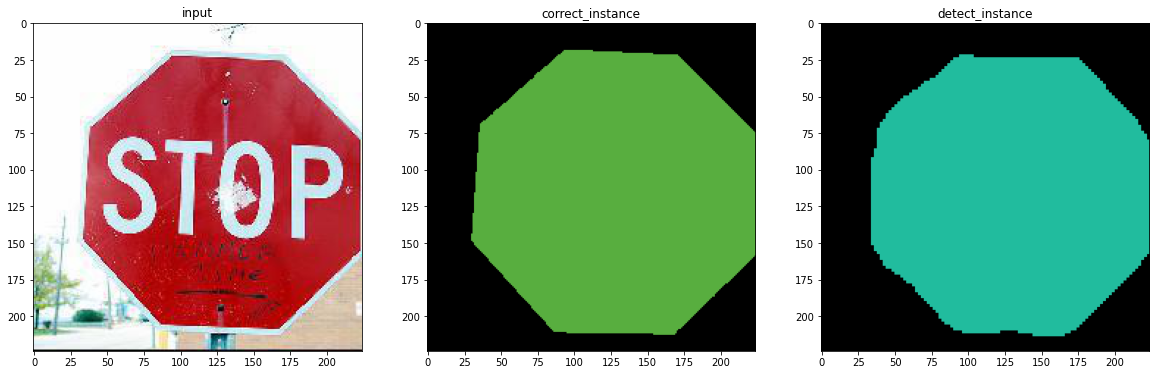

In [42]:
cls_ind = 11
img_ind = 3
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

fork 24806
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000356349.jpg


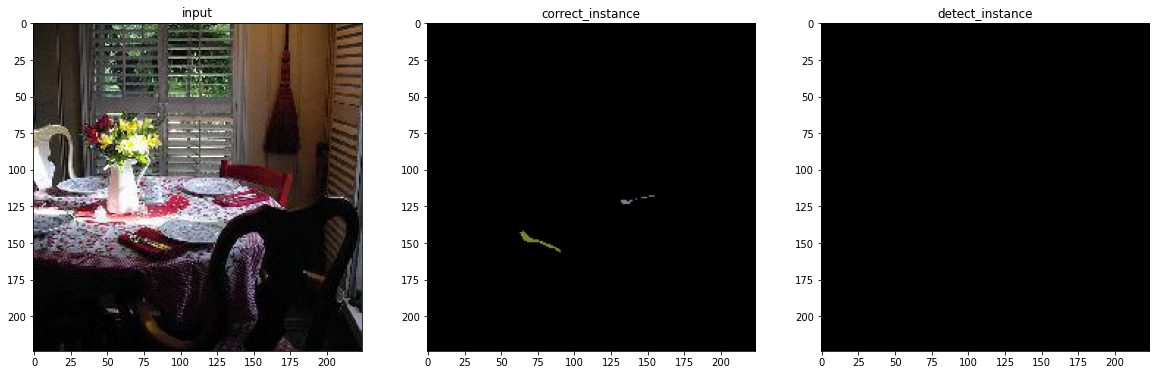

In [63]:
cls_ind = 42
img_ind = 736
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

## Calc metrics

In [21]:
# mIoU
intersection = np.zeros((len(t_color)-1))
union = np.zeros((len(t_color)-1))
iou = np.zeros((len(t_color)-1))
t_area = np.zeros((len(t_color)-1))

for ind in tqdm(range(len(img_path))):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))

    img = preprocess(img)

    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))
    inputs[0] = transform(img)

    with torch.no_grad():
        outputs = model(inputs.to(device))

    output = outputs[4].cpu().detach().numpy()
    output = np.array(np.argmax(output[0], axis=0))

    for cls_ in range(len(t_color)-1):
        output_cls = np.where(output==cls_, 1, 0)
        img_t_cls = np.where((img_t[:, :, 0] == t_color[cls_][0])
                             & (img_t[:, :, 1] == t_color[cls_][1])
                             & (img_t[:, :, 2] == t_color[cls_][2]), 1, 0)
        union[cls_] += np.sum(np.where((output_cls + img_t_cls)>0, 1, 0))
        intersection[cls_] += np.sum(output_cls * img_t_cls)
        t_area[cls_] += np.sum(img_t_cls)

for cls_ in range(len(t_color)-1):
    if union[cls_] == 0:
        iou[cls_] = 0
    else:
        iou[cls_] = intersection[cls_] / union[cls_]

with open(metrics + "metrics_mIoU", mode='w') as f:
    f.write("mIoU:{:.3f}\n"
            .format(np.mean(np.array(iou))))
    for i in range(len(t_color)-1):
        f.write("{}, IoU:{:.3f}, {}, union:{}, t_area:{}, intersection:{}\n"
            .format(i, iou[i], t_class_name[i], union[i],
                    t_area[i], intersection[i]))

np.save(metrics + 'intersection', intersection)
np.save(metrics + 'union', union)
np.save(metrics + 'iou', iou)
np.save(metrics + 't_area', t_area)

100%|██████████| 40504/40504 [53:01<00:00, 12.73it/s]


In [ ]:
# PQ(Panoptic Quality), AP(Average Precision)の計算
TP = np.zeros((len(t_color)-1))
FP = np.zeros((len(t_color)-1))
FN = np.zeros((len(t_color)-1))
IoU_05 = [[] for i in range(len(t_color)-1)]
IoU = np.zeros((len(t_color)-1))
AP = np.zeros((len(t_color)-1))
SQ = np.zeros((len(t_color)-1))
RQ = np.zeros((len(t_color)-1))

st_for=0
en_for=4
min_size=20

for ind in tqdm(range(len(img_path))):
    img = np.asarray(Image.open(img_path[ind]))
    seg_t = np.asarray(Image.open(img_t_path[ind]))
    ins_t = np.asarray(Image.open(img_ins_t_path[ind]))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
        
    detect, ins_list = make_ins_seg(outputs, st_for=st_for,
                                    en_for=en_for, min_size=min_size)

    for cls_ in range(len(t_color)-1):
        # Falseだと、そのクラスが画像中に存在していないことを示す.
        t_flag = False
        d_flag = False

        # 正解ラベル
        # 該当クラスのinstanceのみ取り出す
        mask = np.where((seg_t[:, :, 0] == t_color[cls_][0])
                        & (seg_t[:, :, 1] == t_color[cls_][1])
                        & (seg_t[:, :, 2] == t_color[cls_][2]),
                        1, 0)[..., None]
        ins_t_cls = ins_t * mask
        if np.max(ins_t_cls)!=0:
            t_flag = True
            # instanceを一つずつ224x224のndarrayに分ける
            ins_colors = ins_t_cls.reshape(IMG_SIZE*IMG_SIZE, 3)
            ins_colors = sorted(list(map(list, set(map(tuple, ins_colors)))))[::-1]
            if [0, 0, 0] in ins_colors:
                ins_colors.remove([0, 0, 0])
            t_com = np.zeros((len(ins_colors), IMG_SIZE, IMG_SIZE))

            for i in range(len(ins_colors)):
                t_com[i] = np.where((ins_t_cls[:, :, 0] == ins_colors[i][0])
                                    & (ins_t_cls[:, :, 1] == ins_colors[i][1])
                                    & (ins_t_cls[:, :, 2] == ins_colors[i][2]), 1, 0)

        # 識別結果
        # instanceを一つずつ224x224のndarrayに分ける
        if np.max(detect[cls_])!=0:
            d_flag = True
            ins_colors = detect[cls_].reshape(IMG_SIZE*IMG_SIZE, 3)
            ins_colors = sorted(list(map(list, set(map(tuple, ins_colors)))))[::-1]
            if [0, 0, 0] in ins_colors:
                ins_colors.remove([0, 0, 0])
            det_com = np.zeros((len(ins_colors), IMG_SIZE, IMG_SIZE))
            for i in range(len(ins_colors)):
                det_com[i] = np.where((detect[cls_][:, :, 0] == ins_colors[i][0])
                                      & (detect[cls_][:, :, 1] == ins_colors[i][1])
                                      & (detect[cls_][:, :, 2] == ins_colors[i][2]), 1, 0)

        # t_comとdet_comを比較.
        if t_flag == False and d_flag == False:
            continue
        elif t_flag == True and d_flag == False:
            FN[cls_] += len(t_com)
        elif t_flag == False and d_flag == True:
            FP[cls_] += len(det_com)
        else:
            TP_cls = 0
            for i in range(len(det_com)):
                union = np.sum(np.sum(np.clip(t_com + det_com[i], 0, 1), axis=2), axis=1)
                intersection = np.sum(np.sum(t_com * det_com[i], axis=2), axis=1)

                max_IoU = np.max(intersection / union)
                if max_IoU > 0.5:
                    TP_cls += 1
                    IoU[cls_] += max_IoU
                    IoU_05[cls_].append(max_IoU)
            TP[cls_] += TP_cls
            FP[cls_] += len(det_com) - TP_cls
            FN[cls_] += len(t_com) - TP_cls
            
    if ind % 100 == 0:
        with open(metrics + "log", mode='a') as f:
            f.write("index:{}\n".format(ind))

np.save(metrics + 'TP', TP)
np.save(metrics + 'FP', FP)
np.save(metrics + 'FN', FN)
np.save(metrics + 'PQ_IoU', IoU)

for cls_ in range(len(t_color)-1):
    # Segmentation Quality
    if TP[cls_] == 0:
        SQ[cls_] = 0
    else:
        SQ[cls_] = np.array(IoU[cls_]) / np.array(TP[cls_])
    # Recognition Quality
    denominator = TP[cls_] + FP[cls_]/2 + FN[cls_]/2
    if denominator == 0:
        RQ[cls_] = 0
    else:
        RQ[cls_] = TP[cls_] / denominator
    
    # APの計算
    TP_FP = TP[cls_] + FP[cls_]
    if TP_FP == 0:
        AP[cls_] = 0
        continue
    for thresh in range(50, 100, 5):
        th = thresh / 100
        iou_05 = np.asarray(IoU_05[cls_])
        AP[cls_] += np.sum(np.where(iou_05>th, 1, 0)) / TP_FP
AP = AP / 10

# Panoptic Quality
PQ = SQ * RQ

with open(metrics + "metrics_mAP_mPQ", mode='w') as f:
    f.write("mAP{}, mPQ:{}\n"
            .format(np.mean(AP), np.mean(PQ)))
    for i in range(len(t_color)-1):
        f.write("{}, AP:{:.3f}, PQ:{:.3f}, {}\n"
            .format(i, AP[i], PQ[i], t_class_name[i]))

np.save(metrics + 'SQ', SQ)
np.save(metrics + 'RQ', RQ)
np.save(metrics + 'PQ', PQ)
np.save(metrics + 'AP', AP)